# Mount drive:

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/')
!ls

args_parser	    hyperparam.ini	     sbatch_jean_zay
checkpoints	    main.py		     sbatch_lis_cluster
checkpoints_scores  model.py		     scores.py
data		    notebook		     solver.py
dataset		    parameters_combinations  structural_representation
distributions	    __pycache__		     utils
evaluate.py	    pytorch_FID		     visualizer.py
fig_results	    README.md		     viz


# Modules:

In [10]:
import matplotlib.pyplot as plt
import os
import torch
from model import BetaVAE
from viz.visualize import Visualizer as Viz
import numpy as np

from scipy import stats
from sklearn.decomposition import PCA
from matplotlib import cm

from dataset.dataset_2 import get_dataloaders

# Functions:

In [4]:
def get_checkpoints(net, path, expe_name):
    file_path = os.path.join(path, expe_name, 'last')
    checkpoint = torch.load(file_path, map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint['net'])
    nb_iter = checkpoint['iter']
    # nb_epochs = checkpoint['epochs']
    nb_epochs = nb_iter

    return net, nb_iter, nb_epochs

In [5]:
def get_checkpoints_scores(net, path_scores, expe_name):
    file_path = os.path.join(path_scores, expe_name, 'last')
    checkpoints_scores = torch.load(file_path, map_location=torch.device('cpu'))

    global_iter = checkpoints_scores['iter']
    epochs = checkpoints_scores['epochs']
    Zc_Zd_train = checkpoints_scores['Zc_Zd_train']
    Zc_random_Zd_train = checkpoints_scores['Zc_random_Zd_train']
    Zc_Zd_random_train = checkpoints_scores['Zc_Zd_random_train']
    Zc_pert_Zd_train = checkpoints_scores['Zc_pert_Zd_train']
    Zc_Zd_pert_train = checkpoints_scores['Zc_Zd_pert_train']

    Zc_Zd_test = checkpoints_scores['Zc_Zd_test']
    Zc_random_Zd_test = checkpoints_scores['Zc_random_Zd_test']
    Zc_Zd_random_test = checkpoints_scores['Zc_Zd_random_test']
    Zc_pert_Zd_test = checkpoints_scores['Zc_pert_Zd_test']
    Zc_Zd_pert_test = checkpoints_scores['Zc_Zd_pert_test']

    recon_loss_train_train = checkpoints_scores['recon_loss_train']
    kl_disc_loss_train = checkpoints_scores['kl_class_loss_train']
    kl_cont_loss_train = checkpoints_scores['kl_var_loss_train']
    total_kl_train = checkpoints_scores['total_kld_train']
    beta_vae_loss_train = checkpoints_scores['beta_vae_loss_train']
    classification_random_continue_loss_train = checkpoints_scores['classification_loss_train']
    classification_partial_rand_loss_train = checkpoints_scores['classification_partial_rand_loss_train']
    MSE_loss_train = checkpoints_scores['MSE_loss_train']

    recon_loss_train_test = checkpoints_scores['recon_loss_test']
    kl_disc_loss_test = checkpoints_scores['kl_class_loss_test']
    kl_cont_loss_test = checkpoints_scores['kl_var_loss_test']
    total_kl_test = checkpoints_scores['total_kld_test']
    beta_vae_loss_test = checkpoints_scores['beta_vae_loss_test']
    classification_random_continue_loss_test = checkpoints_scores['classification_loss_test']
    classification_partial_rand_loss_test = checkpoints_scores['classification_partial_rand_loss_test']
    MSE_loss_test = checkpoints_scores['MSE_loss_test']

    one_bit_rand_mean_pred_train = checkpoints_scores['one_bit_rand_mean_pred_train']
    one_bit_rand_std_pred_train = checkpoints_scores['one_bit_rand_std_pred_train']
    one_bit_rand_mean_pred_test = checkpoints_scores['one_bit_rand_mean_pred_test']
    one_bit_rand_std_pred_test = checkpoints_scores['one_bit_rand_std_pred_test']
    one_bit_rand_noised_mean_pred_train = checkpoints_scores['one_bit_rand_noised_mean_pred_train']
    one_bit_rand_noised_std_pred_train = checkpoints_scores['one_bit_rand_noised_std_pred_train']
    one_bit_rand_noised_mean_pred_test = checkpoints_scores['one_bit_rand_noised_mean_pred_test']
    one_bit_rand_noised_std_pred_test = checkpoints_scores['one_bit_rand_noised_std_pred_test']

    return net, global_iter, epochs, Zc_Zd_train, Zc_random_Zd_train, Zc_Zd_random_train, Zc_pert_Zd_train, Zc_Zd_pert_train, \
           Zc_Zd_test, Zc_random_Zd_test, Zc_Zd_random_test, Zc_pert_Zd_test, Zc_Zd_pert_test, recon_loss_train_train, \
           kl_disc_loss_train, kl_cont_loss_train, total_kl_train, beta_vae_loss_train, \
           classification_random_continue_loss_train, recon_loss_train_test, kl_disc_loss_test, kl_cont_loss_test, \
           total_kl_test, beta_vae_loss_test, classification_random_continue_loss_test, classification_partial_rand_loss_train, \
           classification_partial_rand_loss_test, MSE_loss_train, MSE_loss_test, one_bit_rand_mean_pred_train, one_bit_rand_mean_pred_test, \
           one_bit_rand_std_pred_train, one_bit_rand_std_pred_test, one_bit_rand_noised_mean_pred_train, one_bit_rand_noised_mean_pred_test, \
           one_bit_rand_noised_std_pred_train, one_bit_rand_noised_std_pred_test

In [6]:
def viz_reconstruction(net, nb_epochs, expe_name, batch, latent_spec, both_continue,
                       both_discrete=False, is_partial_rand_class=False,
                       partial_reconstruciton=False, is_E1=False):
    viz = Viz(net, img_size, latent_spec)
    viz.save_images = False

    recon_grid, recon_grid_random_var, recon_grid_random_classe, x_recon, recon_loss, recons_random_variability_loss, \
    recons_random_classe_loss = viz.reconstructions(batch, size=(8, 8),
                                                    both_continue=both_continue,
                                                    both_discrete=both_discrete,
                                                    partial_reconstruciton=partial_reconstruciton,
                                                    is_partial_rand_class=is_partial_rand_class,
                                                    is_E1=is_E1)

    if partial_reconstruciton:
        print(expe_name)
        recon_loss_arounded = np.around(recon_loss, 2)
        recon_loss_arounded_rand_var = np.around(recons_random_variability_loss, 2)
        recon_loss_arounded_rand_classe = np.around(recons_random_classe_loss, 2)
        # grid with originals data
        plt.figure(figsize=(10, 10))
        recon_grid = recon_grid.permute(1, 2, 0)
        plt.title('reconstruction with originals data: nb_epochs: {}, score_recons: {}'.format(nb_epochs,
                                                                                               recon_loss_arounded))
        plt.imshow(recon_grid.numpy())
        plt.show()

        # grid with random var data
        plt.figure(figsize=(10, 10))
        recon_grid_random_var = recon_grid_random_var.permute(1, 2, 0)
        plt.title('reconstruction with random var data: nb_epochs: {}, score_recons: {}'.format(nb_epochs,
                                                                                                recon_loss_arounded_rand_var))
        plt.imshow(recon_grid_random_var.numpy())
        plt.show()

        # grid with random classes data
        plt.figure(figsize=(10, 10))
        recon_grid_random_classe = recon_grid_random_classe.permute(1, 2, 0)
        plt.title('reconstruction with random classes data: nb_epochs: {}, score_recons: {}'.format(nb_epochs,
                                                                                                    recon_loss_arounded_rand_classe))
        plt.imshow(recon_grid_random_classe.numpy())
        plt.show()
    else:
        recon_loss_arounded = np.around(recon_loss, 2)
        plt.figure(figsize=(10, 10))
        recon_grid = recon_grid.permute(1, 2, 0)
        plt.title('reconstruction: model: {}, nb_epochs trained: {}, score_recons: {}'.format(expe_name, nb_epochs,
                                                                                              recon_loss_arounded))
        plt.imshow(recon_grid.numpy())
        plt.show()

    return

In [7]:
def plot_scores_results(epochs, Zc_Zd_train, Zc_random_Zd_train, Zc_Zd_random_train, Zc_pert_Zd_train,
                        Zc_Zd_pert_train, Zc_Zd_test, Zc_random_Zd_test, Zc_Zd_random_test, Zc_pert_Zd_test,
                        Zc_Zd_pert_test, expe_name, is_wt_random, save):
    fig, ax = plt.subplots(figsize=(15, 10), facecolor='w', edgecolor='k')

    ax.set(xlabel='nb_iter', ylabel='accuracy (%)',
           title=('MNIST scores: ' + expe_name))  # ylim=(0,1))

    ax.plot(epochs, Zc_Zd_train, label='Zc_Zd_train')
    ax.plot(epochs, Zc_random_Zd_train, label='Zc_random_Zd_train')
    ax.plot(epochs, Zc_Zd_random_train, label='Zc_Zd_random_train')
    ax.plot(epochs, Zc_Zd_test, label='Zc_Zd_test')
    ax.plot(epochs, Zc_random_Zd_test, label='Zc_random_Zd_test')
    ax.plot(epochs, Zc_Zd_random_test, label='Zc_Zd_random_test')

    ax.legend(loc=1)
    plt.show()

    if save:
        fig.savefig("fig_results/scores/fig_scores_Test_Mnist_L3_Classifier_" + expe_name + ".png")

    return

In [8]:
def plot_loss_results(epochs, recon_loss_train_train, kl_disc_loss_train, kl_cont_loss_train, total_kl_train,
                      beta_vae_loss_train, classification_random_continue_loss_train, recon_loss_train_test,
                      kl_disc_loss_test, kl_cont_loss_test, total_kl_test, beta_vae_loss_test,
                      classification_random_continue_loss_test, classification_partial_rand_loss_train,
                      classification_partial_rand_loss_test, MSE_loss_train, MSE_loss_test, expe_name, is_wt_random,
                      is_both_continuous, save, partial_rand=False):
    fig, ax = plt.subplots(figsize=(15, 10), facecolor='w', edgecolor='k')

    ax.set(xlabel='nb_iter', ylabel='Loss',
           title=('MNIST loss: ' + expe_name))  # ylim=(0,1))

    ax.plot(epochs, recon_loss_train_train, label='recon_loss_train_train', color='royalblue')
    ax.plot(epochs, recon_loss_train_test, label='recon_loss_train_test', color='cornflowerblue')

    if is_both_continuous:
        ax.plot(epochs, kl_disc_loss_train, label='kl_cont_var_train', color='gold')
        ax.plot(epochs, kl_cont_loss_train, label='kl_cont_var_train', color='burlywood')
        ax.plot(epochs, kl_disc_loss_test, label='kl_cont_struct_test', color='goldenrod')
        ax.plot(epochs, kl_cont_loss_test, label='kl_cont_struct_test', color='tan')
    else:
        ax.plot(epochs, kl_disc_loss_train, label='kl_disc_loss_train')
        ax.plot(epochs, kl_cont_loss_train, label='kl_cont_loss_train')
        ax.plot(epochs, kl_disc_loss_test, label='kl_disc_loss_test')
        ax.plot(epochs, kl_cont_loss_test, label='kl_cont_loss_test')

    ax.plot(epochs, total_kl_train, label='total_kl_train', color='orange')
    ax.plot(epochs, total_kl_test, label='total_kl_test', color='darkorange')

    if not is_wt_random:
        ax.plot(epochs, classification_random_continue_loss_train, label='classification_random_continue_loss_train',
                color='dodgerblue')
        ax.plot(epochs, classification_random_continue_loss_test, label='classification_random_continue_loss_test',
                color='deepskyblue')

    if partial_rand:
        ax.plot(epochs, classification_partial_rand_loss_train, label='class partial rand train',
                color='mediumturquoise')
        ax.plot(epochs, classification_partial_rand_loss_test, label='class partial rand train', color='lightseagreen')

    ax.plot(epochs, beta_vae_loss_train, label='beta_vae_loss_train', color='red')
    ax.plot(epochs, beta_vae_loss_test, label='beta_vae_loss_test', color='darkred')

    ax.plot(epochs, MSE_loss_train, label='MSE train', color='green')
    ax.plot(epochs, MSE_loss_test, label='MSE test', color='darkgreen')

    ax.legend(loc=1)

    plt.show()

    if save:
        fig.savefig("fig_results/losses/fig_losses_Test_Mnist_L3_Classifier_" + expe_name + ".png")

    return

In [9]:
def plot_scores_and_loss(net, expe_name, is_wt_random=False, is_both_continuous=True, save=False, partial_rand=False):
    # net, nb_iter, epochs = get_checkpoints(net, path, expe_name)
    net, global_iter, epochs, Zc_Zd_train, Zc_random_Zd_train, Zc_Zd_random_train, Zc_pert_Zd_train, Zc_Zd_pert_train, \
    Zc_Zd_test, Zc_random_Zd_test, Zc_Zd_random_test, Zc_pert_Zd_test, Zc_Zd_pert_test, recon_loss_train_train, \
    kl_disc_loss_train, kl_cont_loss_train, total_kl_train, beta_vae_loss_train, \
    classification_random_continue_loss_train, recon_loss_train_test, kl_disc_loss_test, kl_cont_loss_test, \
    total_kl_test, beta_vae_loss_test, classification_random_continue_loss_test, classification_partial_rand_loss_train, \
    classification_partial_rand_loss_test, MSE_loss_train, MSE_loss_test, one_bit_rand_mean_pred_train, one_bit_rand_mean_pred_test, \
    one_bit_rand_std_pred_train, one_bit_rand_std_pred_test, one_bit_rand_noised_mean_pred_train, one_bit_rand_noised_mean_pred_test, \
    one_bit_rand_noised_std_pred_train, one_bit_rand_noised_std_pred_test = \
        get_checkpoints_scores(net, path_scores, expe_name)

    plot_scores_results(epochs, Zc_Zd_train, Zc_random_Zd_train, Zc_Zd_random_train, Zc_pert_Zd_train,
                        Zc_Zd_pert_train, Zc_Zd_test, Zc_random_Zd_test, Zc_Zd_random_test, Zc_pert_Zd_test,
                        Zc_Zd_pert_test, expe_name, is_wt_random, save)
    plot_loss_results(epochs, recon_loss_train_train, kl_disc_loss_train, kl_cont_loss_train, total_kl_train,
                      beta_vae_loss_train, classification_random_continue_loss_train, recon_loss_train_test,
                      kl_disc_loss_test, kl_cont_loss_test, total_kl_test, beta_vae_loss_test,
                      classification_random_continue_loss_test, classification_partial_rand_loss_train,
                      classification_partial_rand_loss_test, MSE_loss_train, MSE_loss_test, expe_name, is_wt_random,
                      is_both_continuous, save, partial_rand=partial_rand)

    return

In [15]:
def plot_average_z_structural(net_trained, loader, device, nb_class, latent_spec, expe_name,
                              train_test='train', both_continue=True, is_E1=False,
                              return_z_struct_representation=False, is_partial_rand_class=False):
    """
    We average z_struct for all images of a specific class and decode it.
    We want to visualize the structural prototype for each classes.
    :return:
    """
    # 1) net eval mode: froward all images in E
    # 2) get z_struct and label associated for all data
    # 3) average representation z_struct per different classes
    # 4) decode each average representation with D (with random z_var)

    path = 'structural_representation/average_representation_z_struct_class_' + expe_name + '_' + train_test + '.npy'

    if not os.path.exists(path) or return_z_struct_representation:
        # latent representation dimension:

        labels_list = []
        z_struct_representation = []
        average_representation_z_struct_class = []

        for data, labels in loader:

            # evaluation mode:
            net_trained.eval()

            with torch.no_grad():
                input_data = data
            if torch.cuda.is_available():
                input_data = input_data.cuda()

            _, _, _, _, latent_sample, latent_sample_variability, latent_sample_class, _, _, _, \
            _, _, _, _, _, _, _ = net_trained(input_data,
                                              reconstruction_rand=True,
                                              both_continue=both_continue,
                                              is_partial_rand_class=is_partial_rand_class,
                                              is_E1=is_E1)
            # train mode:
            net_trained.eval()

            labels_list.extend(labels.detach().numpy())
            z_struct_batch = latent_sample_class.detach().numpy()
            z_struct_representation.extend(z_struct_batch)

        z_struct_representation = np.array(z_struct_representation)  # shape: (nb_data, z_struct_dim)

        if return_z_struct_representation:
            return z_struct_representation, labels_list

        # average representation:
        for i in range(nb_class):
            z_struct_class = []
            for j in range(len(labels_list)):
                if labels_list[j] == i:
                    z_struct_class.append(z_struct_representation[j])
            z_struct_class = np.array(z_struct_class)
            average_z_struct_class = np.mean(z_struct_class, axis=0)
            average_representation_z_struct_class.append(average_z_struct_class)

        average_representation_z_struct_class = np.array(average_representation_z_struct_class)
        # shape: (nb_class, z_struct_dim)
        print('average_representation_z_struct_class shape: ', average_representation_z_struct_class.shape)

        np.save('structural_representation'
                '/average_representation_z_struct_class_' + expe_name + '_' +
                train_test + '.npy', average_representation_z_struct_class)
    else:
        average_representation_z_struct_class = np.load('structural_representation'
                                                        '/average_representation_z_struct_class_' + expe_name + '_' +
                                                        train_test + '.npy', allow_pickle=True)
        print('load average z_struct per class: {}'.format(average_representation_z_struct_class.shape))

    # Decode:
    # build z with z_var rand and prototype:
    z_var_rand = torch.randn(latent_spec['cont_var'])
    z_var_rand = z_var_rand.to(device)

    # plot:
    images_arr = []
    labels_arr = np.arange(nb_class)

    for i in range(nb_class):
        latent = []
        z_struct_prototype = torch.tensor(average_representation_z_struct_class[i]).to(device)
        latent.append(z_var_rand)
        latent.append(z_struct_prototype)

        latent = torch.cat(latent, dim=0)

        prototype = net_trained._decode(latent).detach().numpy()
        images_arr.append(prototype[0][0])

    fig = plt.figure(figsize=(10, 5))
    plt.title('z_struct prototype: {} {}'.format(expe_name, train_test))
    plt.axis('off')
    for i in range(nb_class):
        ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.reshape(images_arr[i], (1, prototype[0].shape[-1], prototype[0].shape[-2]))[0], cmap='gray')
        ax.set_title("({})".format(labels_arr[i]))

    plt.show()

    return

In [16]:
def plot_prototyoe_z_struct_per_class(nb_examples, average_representation_z_struct_class, train_test, expe_name):
    """
    plot prototyoe z_struct per class
    :return:
    """

    for i in range(nb_examples):
        # plot:
        images_arr = []
        labels_arr = np.arange(nb_class)
        z_var_rand = torch.randn(latent_spec['cont_var'])
        z_var_rand = z_var_rand.to(device)

        for j in range(nb_class):
            latent = []
            z_struct_prototype = torch.tensor(average_representation_z_struct_class[j]).to(device)
            latent.append(z_var_rand)
            latent.append(z_struct_prototype)

            latent = torch.cat(latent, dim=0)
            prototype = net._decode(latent).detach().numpy()
            images_arr.append(prototype[0][0])

        fig = plt.figure(figsize=(10, 5))
        plt.title('z_struct fix with variational rand z_var for example {}: {} {}'.format(i, expe_name, train_test))
        plt.axis('off')

        for k in range(nb_class):
            ax = fig.add_subplot(2, 5, k + 1, xticks=[], yticks=[])
            ax.imshow(np.reshape(images_arr[k], (1, prototype[0].shape[-1], prototype[0].shape[-2]))[0],
                      cmap='gray')
            ax.set_title("({})".format(labels_arr[k]))
        plt.show()

    return

# MNIST:

## Parameters:

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch = torch.load('data/batch_mnist.pt')
path = 'checkpoints/'
path_scores = 'checkpoints_scores'

# load mnist dataset:
train_loader, valid_loader, test_loader = get_dataloaders('mnist', batch_size=64)

img_size = (1, 32, 32)
nb_class = 10
nb_samples = 10
size = 8
nc = 1
four_conv = False
is_C = True
save = False

L3_without_random = False
is_binary_structural_latent = False

Extracting /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw


Extracting /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw


Extracting /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw


Extracting /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/dataset/../data/mnist/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Load models:

In [11]:
# base:
expe_test = 'mnist_base_5_25_num_1'
expe_name_base = 'mnist_both_cont_num1'

# variantes:
expe_name_E1 = 'mnist_both_cont_E1_num1'
expe_name_MSE = 'mnist_both_cont_MSE_num1'
expe_name_E1_MSE = 'mnist_both_cont_E1_MSE_num1'

expe_name_partial = 'mnist_both_cont_partial_rand_num1'
expe_name_partial_E1 = 'mnist_both_cont_partial_rand_E1_num1'
expe_name_partial_MSE = 'mnist_both_cont_partial_rand_MSE_num1'
expe_name_partial_E1_MSE = 'mnist_both_cont_partial_rand_E1_MSE_num1'

# with grid search on lambda:
expe_base = 'mnist_base'
expe_partial = 'mnist_partial'
expe_partial_E1 = 'mnist_partial_E1'
expe_partial_E1_MSE = 'mnist_partial_E1_MSE'

## Plot scores:

/content/drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Pytorch_vanilla_Beta_VAE/model.py:883: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


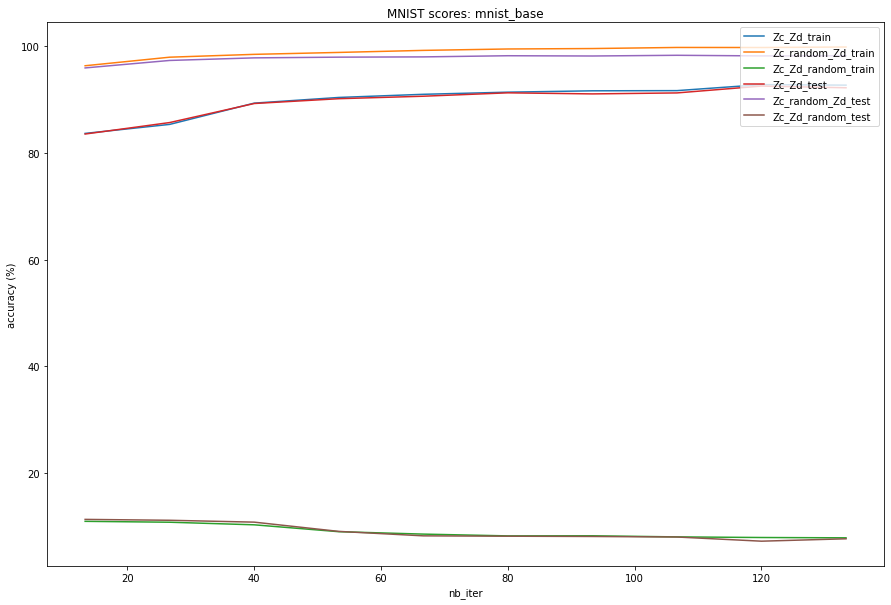

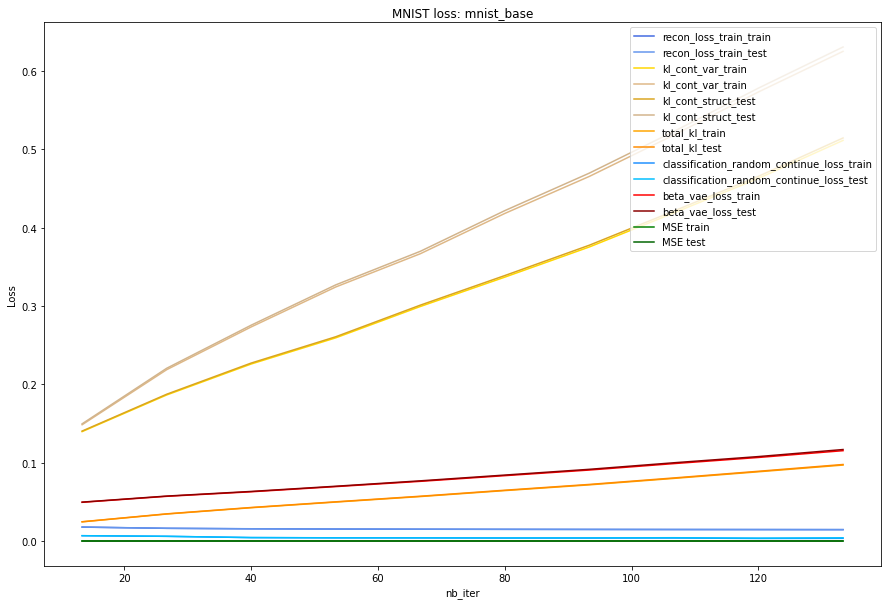

In [14]:
# For expe_base:
latent_spec = {'cont_var': 5, 'cont_class': 25}
both_continue = True
second_layer_C = True
is_MSE_loss = False
is_partial_rand_class = False
is_E1 = False
BN = False

net = BetaVAE(latent_spec, nb_class, is_C, device, nc=nc, four_conv=four_conv, second_layer_C=second_layer_C,
              is_E1=is_E1, BN=BN)
expe_name = expe_base
net_trained, _, nb_epochs = get_checkpoints(net, path, expe_name)

plot_scores_and_loss(net, expe_name, partial_rand=is_partial_rand_class)

## Plot prototype:

load average z_struct per class: (10, 25)


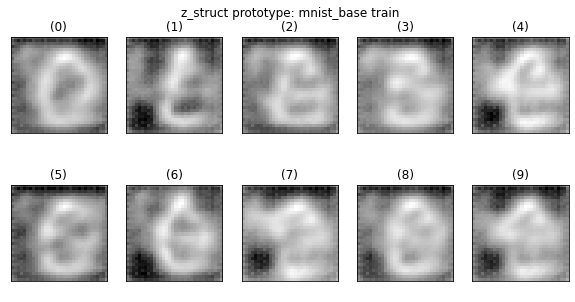

load average z_struct per class: (10, 25)


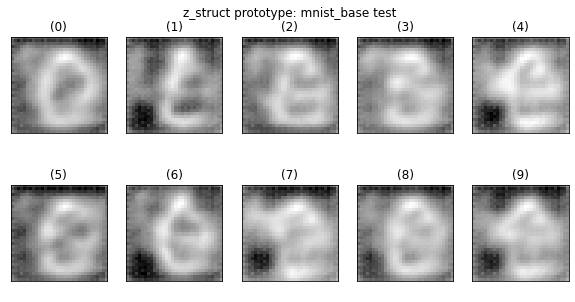

In [17]:
# compute prototype:
plot_average_z_structural(net_trained, train_loader, device, nb_class, latent_spec, expe_name,
                              train_test='train', both_continue=True, is_E1=is_E1,
                              is_partial_rand_class=is_partial_rand_class)
plot_average_z_structural(net_trained, test_loader, device, nb_class, latent_spec, expe_name,
                              train_test='test', both_continue=True, is_E1=is_E1,
                              is_partial_rand_class=is_partial_rand_class)